In [2]:
from Extract_Features import extract_features, feature_selection_SHAP, clustering_selection
from Extract_Features import replace_missing_value
from tsfresh.examples import load_robot_execution_failures
import pandas as pd
import tsfresh
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from ML.feature_selection import FeatureSelection
from ML.model import Model
from ML.process_data import Data
from utils.help_classes import ScalerEnum, ModelsEnum

from utils.help_classes import ModelsEnum
from sklearn.model_selection import train_test_split
import os

import pickle
import numpy as np
import category_encoders as ce

In [50]:
data_train = pd.read_csv(os.path.join('data', 'train.csv'))
data_test = pd.read_csv(os.path.join('data', 'test.csv'))

data_train['time_stamp']= pd.to_datetime(data_train['time_stamp'])
data_test['time_stamp']= pd.to_datetime(data_test['time_stamp'])

print('data_train', data_train.shape)
print('data_test', data_test.shape)

data_train = data_train.drop_duplicates(subset=['x', 'y', 'z', 'traj_ind'])
data_test = data_test.drop_duplicates(subset=['x', 'y', 'z', 'traj_ind'])

print('data_train', data_train.shape)
print('data_test', data_test.shape)

data_train = data_train.drop_duplicates(subset=['x', 'y', 'z', 'time_stamp'])
data_test = data_test.drop_duplicates(subset=['x', 'y', 'z', 'time_stamp'])

print('data_train', data_train.shape)
print('data_test', data_test.shape)

data_train (1021976, 6)
data_test (253393, 5)
data_train (1021976, 6)
data_test (253393, 5)
data_train (1021976, 6)
data_test (253393, 5)


In [5]:
data_train.columns

Index(['label', 'time_stamp', 'traj_ind', 'x', 'y', 'z'], dtype='object')

In [7]:
data_train.head()

,label,time_stamp,traj_ind,x,y,z
0,1,2015-12-29 14:50:34.045000,0,0.814803,0.023350,0.068439
1,1,2015-12-29 14:50:34.095000,0,0.811802,0.015569,0.068855
2,1,2015-12-29 14:50:34.145000,0,0.808880,0.007757,0.073745
3,1,2015-12-29 14:50:34.195000,0,0.806039,-0.000084,0.073402
4,1,2015-12-29 14:50:34.245000,0,0.803278,-0.007953,0.075000


## Balance of classes

In [77]:
data_train_0 = data_train.drop_duplicates(subset=['traj_ind']).loc[data_train['label'] == 0]
data_train_1 = data_train.drop_duplicates(subset=['traj_ind']).loc[data_train['label'] == 1]
data_train_2 = data_train.drop_duplicates(subset=['traj_ind']).loc[data_train['label'] == 2]

print('data_train_0', data_train_0.shape)
print('data_train_1', data_train_1.shape)
print('data_train_2', data_train_2.shape)

data_train_0 (22462, 6)
data_train_1 (7940, 6)
data_train_2 (2339, 6)


## Number of traj per split set

In [11]:
nb_traj_train = data_train['traj_ind'].unique()
nb_traj_test = data_test['traj_ind'].unique()

print('nb_traj_train', len(nb_traj_train))
print('nb_traj_test', len(nb_traj_test))

nb_traj_train 32741
nb_traj_test 8185


## Visualization of trajectories per label

In [57]:
def plot_traj_label(data, label):
    data_label = data.loc[data['label'] == label]
    nb_traj_train = data_label['traj_ind'].unique()

    for i, traj in enumerate(nb_traj_train):
        data_traj = data_label.loc[data_label['traj_ind'] == traj]

        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(data_traj['x'], data_traj['y'], data_traj['z'])
        plt.title(str(data_traj['label'].values[0]) + '_' + str(traj))
        plt.show()

        if i == 3:
            break

     label              time_stamp  traj_ind         x         y         z
428      0 2014-12-31 09:19:11.700        12  0.543709  0.150330  0.038735
429      0 2014-12-31 09:19:11.750        12  0.545476  0.158336  0.043825
430      0 2014-12-31 09:19:11.800        12  0.547170  0.166357  0.044627
431      0 2014-12-31 09:19:11.800        12  0.548791  0.174394  0.047793
432      0 2014-12-31 09:19:11.900        12  0.550338  0.182445  0.050537
433      0 2014-12-31 09:19:11.900        12  0.551812  0.190511  0.051859
434      0 2014-12-31 09:19:12.000        12  0.553213  0.198589  0.051119
435      0 2014-12-31 09:19:12.000        12  0.554540  0.206679  0.051398
436      0 2014-12-31 09:19:12.100        12  0.555793  0.214782  0.054517
437      0 2014-12-31 09:19:12.150        12  0.556972  0.222895  0.053006
438      0 2014-12-31 09:19:12.200        12  0.558077  0.231019  0.056651
439      0 2014-12-31 09:19:12.200        12  0.559108  0.239152  0.058198
440      0 2014-12-31 09:

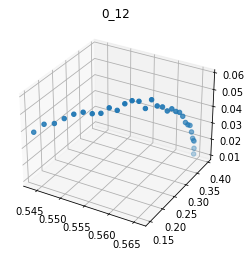

     label                 time_stamp  traj_ind         x         y         z
459      0 2014-12-31 09:19:16.641488        13  0.543709  0.150330  0.038735
460      0 2014-12-31 09:19:16.691488        13  0.545476  0.158336  0.043825
461      0 2014-12-31 09:19:16.741488        13  0.547170  0.166357  0.044627
462      0 2014-12-31 09:19:16.791488        13  0.548791  0.174394  0.047793
463      0 2014-12-31 09:19:16.841488        13  0.550338  0.182445  0.050537
464      0 2014-12-31 09:19:16.891488        13  0.551812  0.190511  0.051859
465      0 2014-12-31 09:19:16.941488        13  0.553213  0.198589  0.051119
466      0 2014-12-31 09:19:16.991488        13  0.554540  0.206679  0.051398
467      0 2014-12-31 09:19:17.041488        13  0.555793  0.214782  0.054517
468      0 2014-12-31 09:19:17.091488        13  0.556972  0.222895  0.053006
469      0 2014-12-31 09:19:17.141488        13  0.558077  0.231019  0.056651
470      0 2014-12-31 09:19:17.191488        13  0.559108  0.239

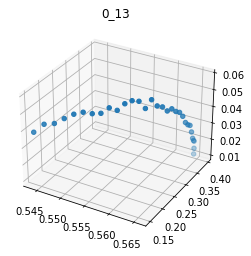

     label                 time_stamp  traj_ind         x         y         z
490      0 2014-12-31 09:19:21.582976        14  0.543709  0.150330  0.038735
491      0 2014-12-31 09:19:21.632976        14  0.545476  0.158336  0.043825
492      0 2014-12-31 09:19:21.682976        14  0.547170  0.166357  0.044627
493      0 2014-12-31 09:19:21.732976        14  0.548791  0.174394  0.047793
494      0 2014-12-31 09:19:21.782976        14  0.550338  0.182445  0.050537
495      0 2014-12-31 09:19:21.832976        14  0.551812  0.190511  0.051859
496      0 2014-12-31 09:19:21.882976        14  0.553213  0.198589  0.051119
497      0 2014-12-31 09:19:21.932976        14  0.554540  0.206679  0.051398
498      0 2014-12-31 09:19:21.982976        14  0.555793  0.214782  0.054517
499      0 2014-12-31 09:19:21.982976        14  0.556972  0.222895  0.053006
500      0 2014-12-31 09:19:22.082976        14  0.558077  0.231019  0.056651
501      0 2014-12-31 09:19:22.132976        14  0.559108  0.239

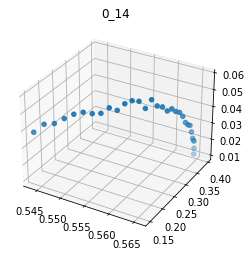

     label                 time_stamp  traj_ind         x         y         z
521      0 2014-12-31 09:19:26.524464        15  0.543709  0.150330  0.038735
522      0 2014-12-31 09:19:26.524464        15  0.545476  0.158336  0.043825
523      0 2014-12-31 09:19:26.624464        15  0.547170  0.166357  0.044627
524      0 2014-12-31 09:19:26.674464        15  0.548791  0.174394  0.047793
525      0 2014-12-31 09:19:26.724464        15  0.550338  0.182445  0.050537
526      0 2014-12-31 09:19:26.774464        15  0.551812  0.190511  0.051859
527      0 2014-12-31 09:19:26.824464        15  0.553213  0.198589  0.051119
528      0 2014-12-31 09:19:26.874464        15  0.554540  0.206679  0.051398
529      0 2014-12-31 09:19:26.924464        15  0.555793  0.214782  0.054517
530      0 2014-12-31 09:19:26.924464        15  0.556972  0.222895  0.053006
531      0 2014-12-31 09:19:26.924464        15  0.558077  0.231019  0.056651
532      0 2014-12-31 09:19:27.074464        15  0.559108  0.239

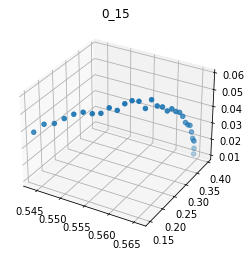

In [58]:
plot_traj_label(data_train, 0)

'''
428      0 2014-12-31 09:19:11.700        12  0.543709  0.150330  0.038735
459      0 2014-12-31 09:19:16.641488        13  0.543709  0.150330  0.038735
490      0 2014-12-31 09:19:21.582976        14  0.543709  0.150330  0.038735
'''

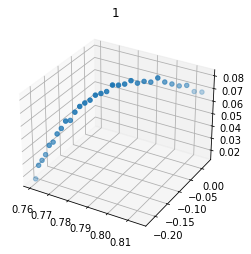

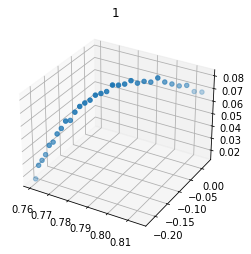

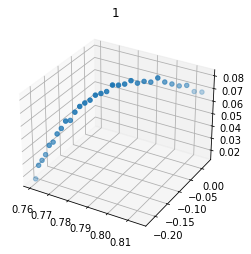

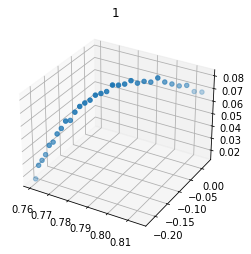

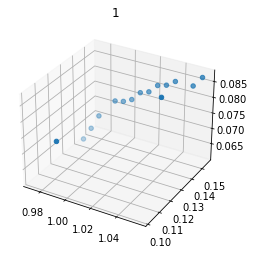

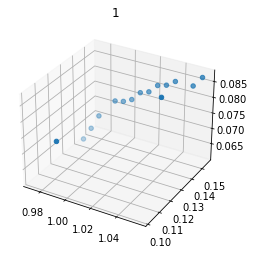

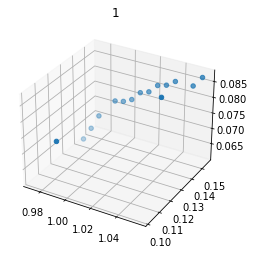

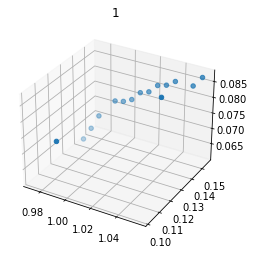

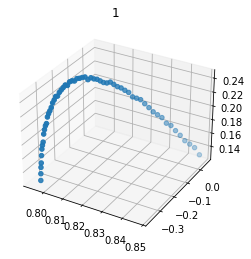

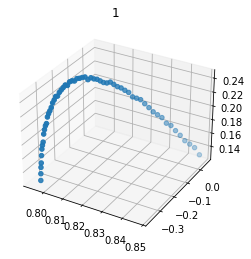

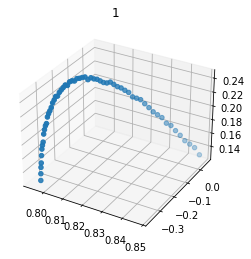

In [19]:
plot_traj_label(data_train, 1)

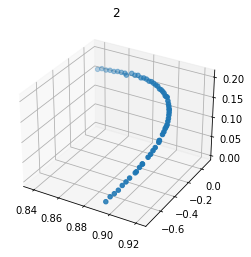

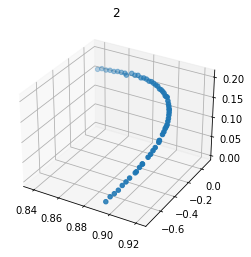

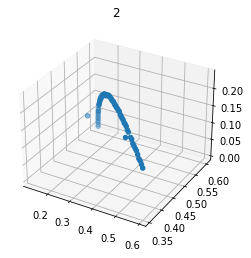

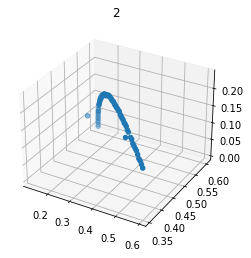

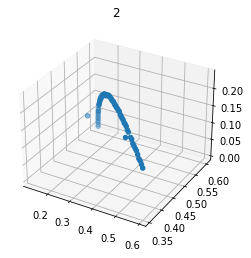

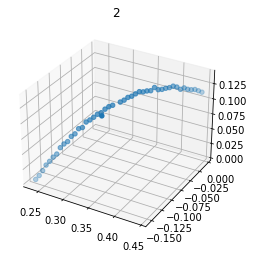

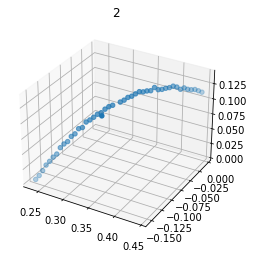

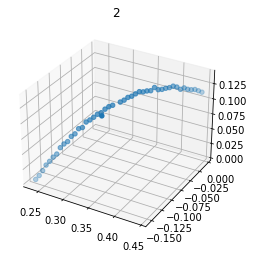

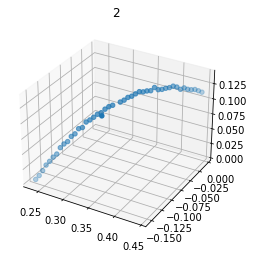

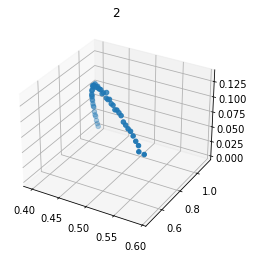

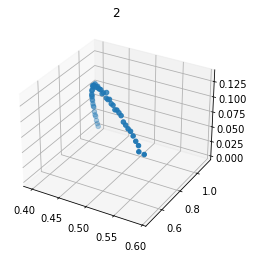

In [20]:
plot_traj_label(data_train, 2)

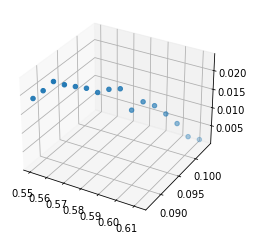

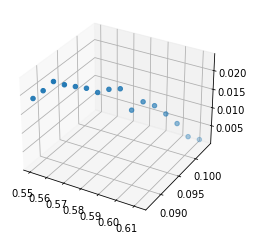

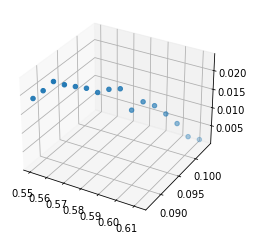

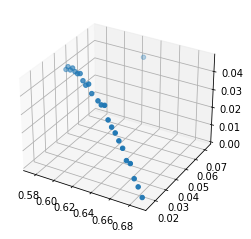

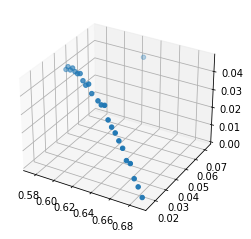

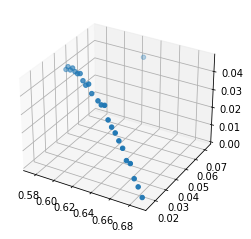

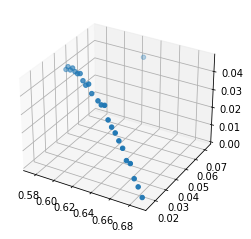

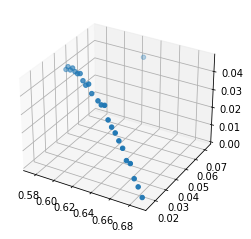

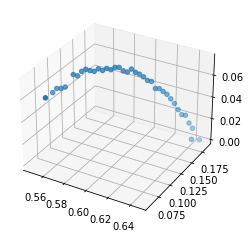

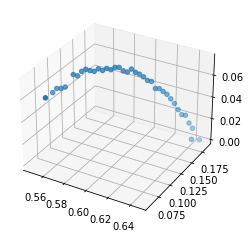

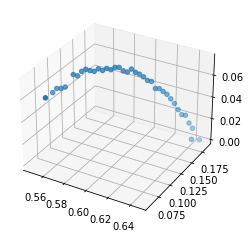

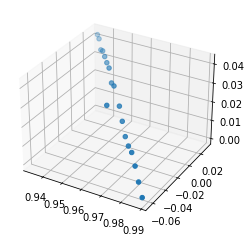

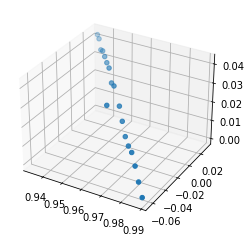

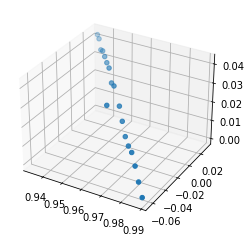

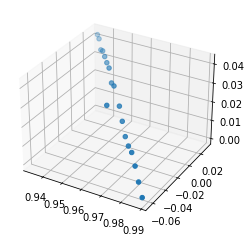

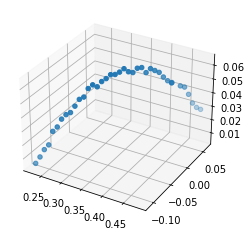

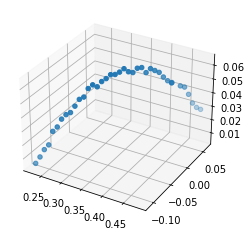

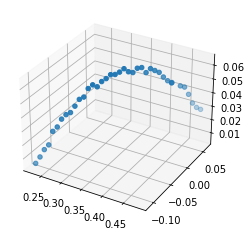

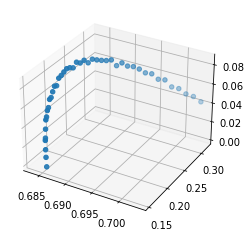

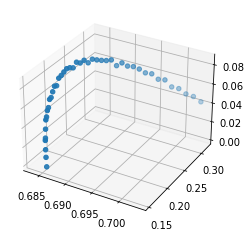

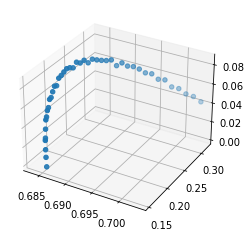

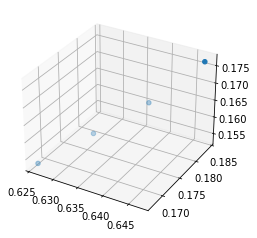

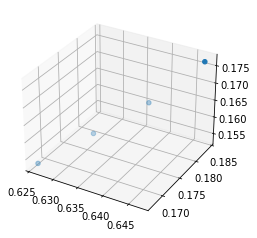

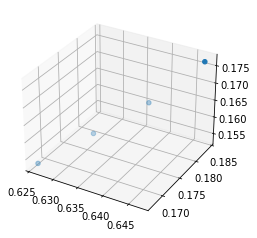

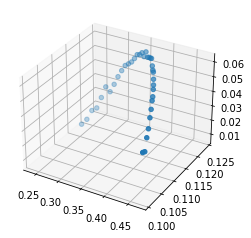

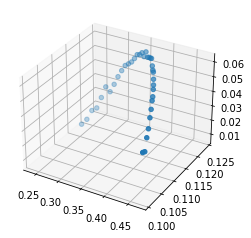

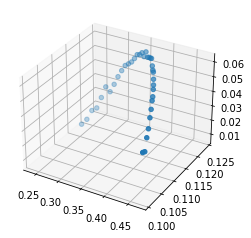

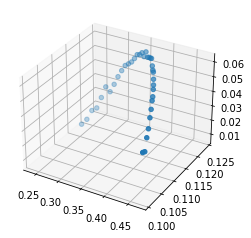

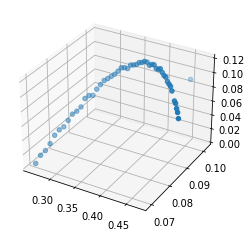

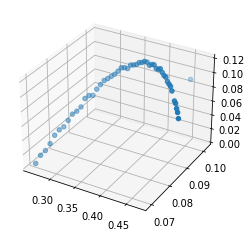

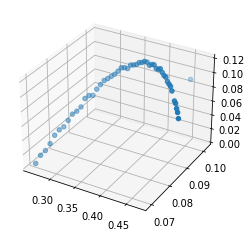

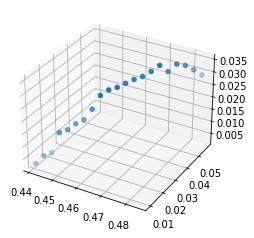

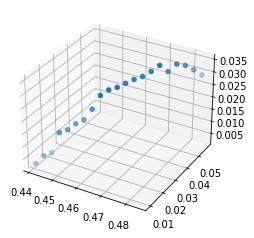

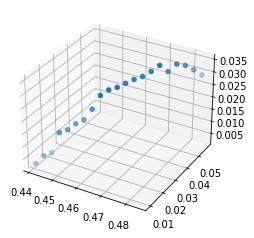

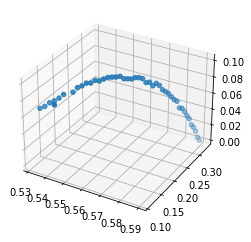

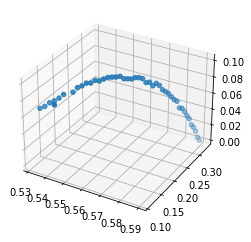

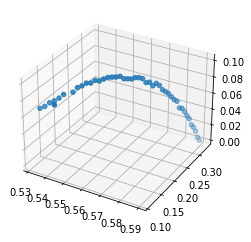

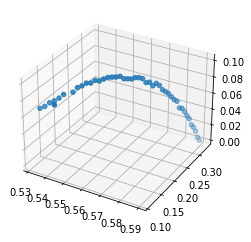

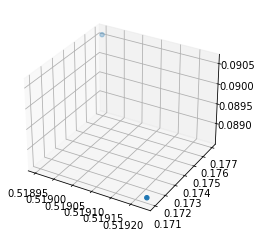

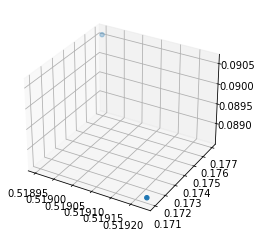

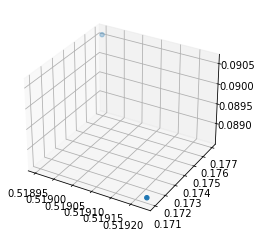

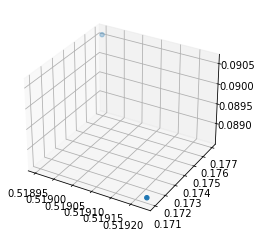

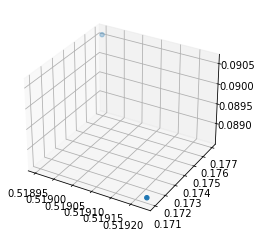

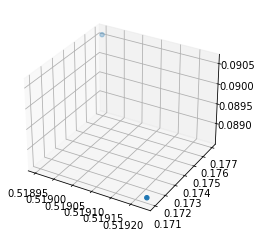

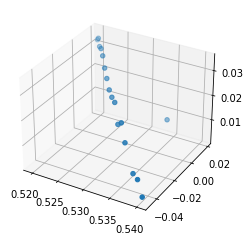

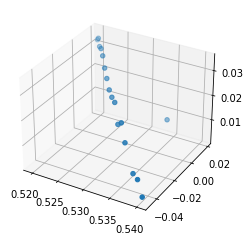

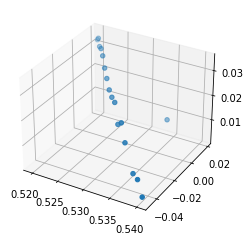

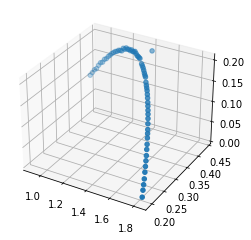

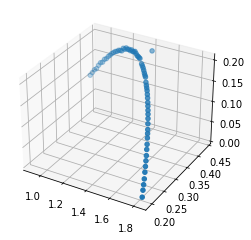

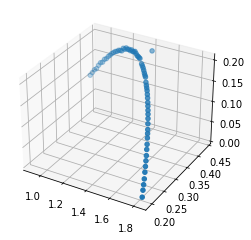

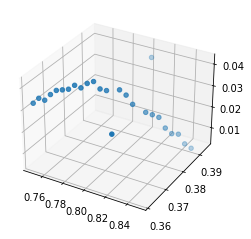

In [41]:
nb_traj_test = data_test['traj_ind'].unique()

for i, traj in enumerate(nb_traj_test):
    data_traj = data_test.loc[data_test['traj_ind'] == traj]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(data_traj['x'], data_traj['y'], data_traj['z'])
    plt.show()

    if i == 50:
        break

## Number of samples per trajectory 

In [32]:
def stat_per_label(data, label):
    data_label = data.loc[data['label'] == label]
    count = data_label.groupby(['traj_ind']).agg(['count'])
    
    plt.figure()
    plt.hist(count['label']['count'])
    plt.show()

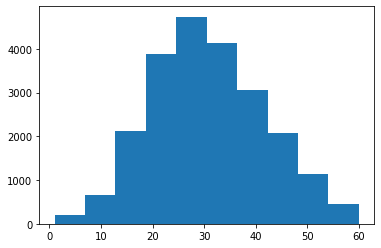

In [33]:
stat_per_label(data_train, 0)

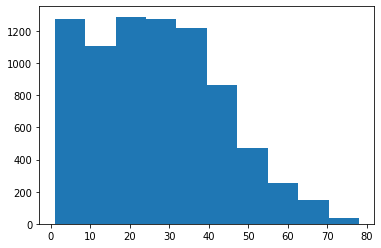

In [34]:
stat_per_label(data_train, 1)

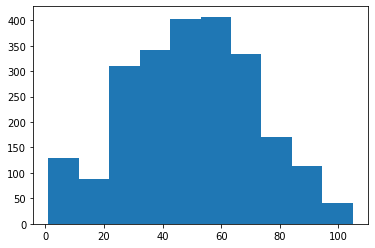

In [35]:
stat_per_label(data_train, 2)

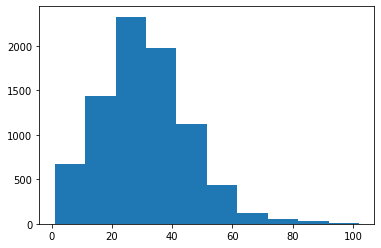

In [38]:
count = data_test.groupby(['traj_ind']).agg(['count'])

plt.figure()
plt.hist(count['time_stamp']['count'])
plt.show()

## Timestamp

In [32]:
data_train = pd.read_csv(os.path.join('data', 'train.csv'))
data_test = pd.read_csv(os.path.join('data', 'test.csv'))

data_train['time_stamp']= pd.to_datetime(data_train['time_stamp'])
data_test['time_stamp']= pd.to_datetime(data_test['time_stamp'])

In [13]:
data_train.dtypes

label                  int64
time_stamp    datetime64[ns]
traj_ind               int64
x                    float64
y                    float64
z                    float64
dtype: object

In [38]:
data_train_subset = data_train.drop_duplicates(subset=['traj_ind'])
data_train_subset.shape

(32741, 6)

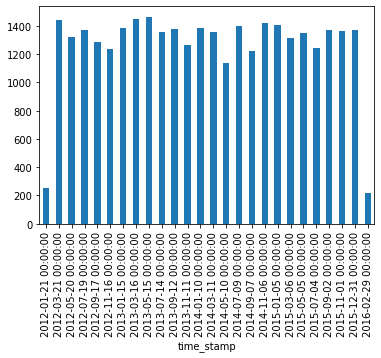

In [46]:
res = data_train_subset['label'].groupby(data_train_subset["time_stamp"].dt.round('60D')).count()
res.plot(kind="bar")
plt.show()

In [47]:
data_test_subset = data_test.drop_duplicates(subset=['traj_ind'])
data_test_subset.shape

(8185, 5)

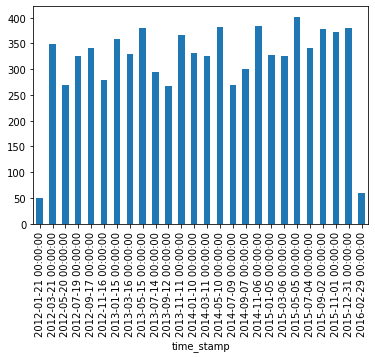

In [49]:
res = data_test_subset['x'].groupby(data_test_subset["time_stamp"].dt.round('60D')).count()
res.plot(kind="bar")
plt.show()

## Split according to time_stamp

In [61]:
data_train['time_stamp'].quantile(q=0.8)

Timestamp('2015-04-29 06:47:22.340999936')

In [63]:
X_train = data_train.loc[data_train['time_stamp'] < data_train['time_stamp'].quantile(q=0.8)]
X_val = data_train.loc[data_train['time_stamp'] >= data_train['time_stamp'].quantile(q=0.8)]

In [64]:
print('X_train', X_train.shape)
print('X_val', X_val.shape)

X_train (817580, 6)
X_val (204396, 6)
